In [2]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

# Check if the directory exists, and create it if it doesn't
directory_path = 'gdrive/My Drive/Colab Notebooks/ImageSegmentation'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Created directory: {directory_path}")

os.chdir(directory_path)

Mounted at /content/gdrive


In [3]:
!git clone https://github.com/zhixuhao/unet.git
!unzip unet-master.zip -d unet

Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Updating files: 100% (253/253), done.
unzip:  cannot find or open unet-master.zip, unet-master.zip.zip or unet-master.zip.ZIP.


In [3]:
import glob2

img_5_paths = sorted(glob2.glob('unet/data/membrane/train/image/*.png'))[:5]
label_5_paths = sorted(glob2.glob('unet/data/membrane/train/label/*.png'))[:5]


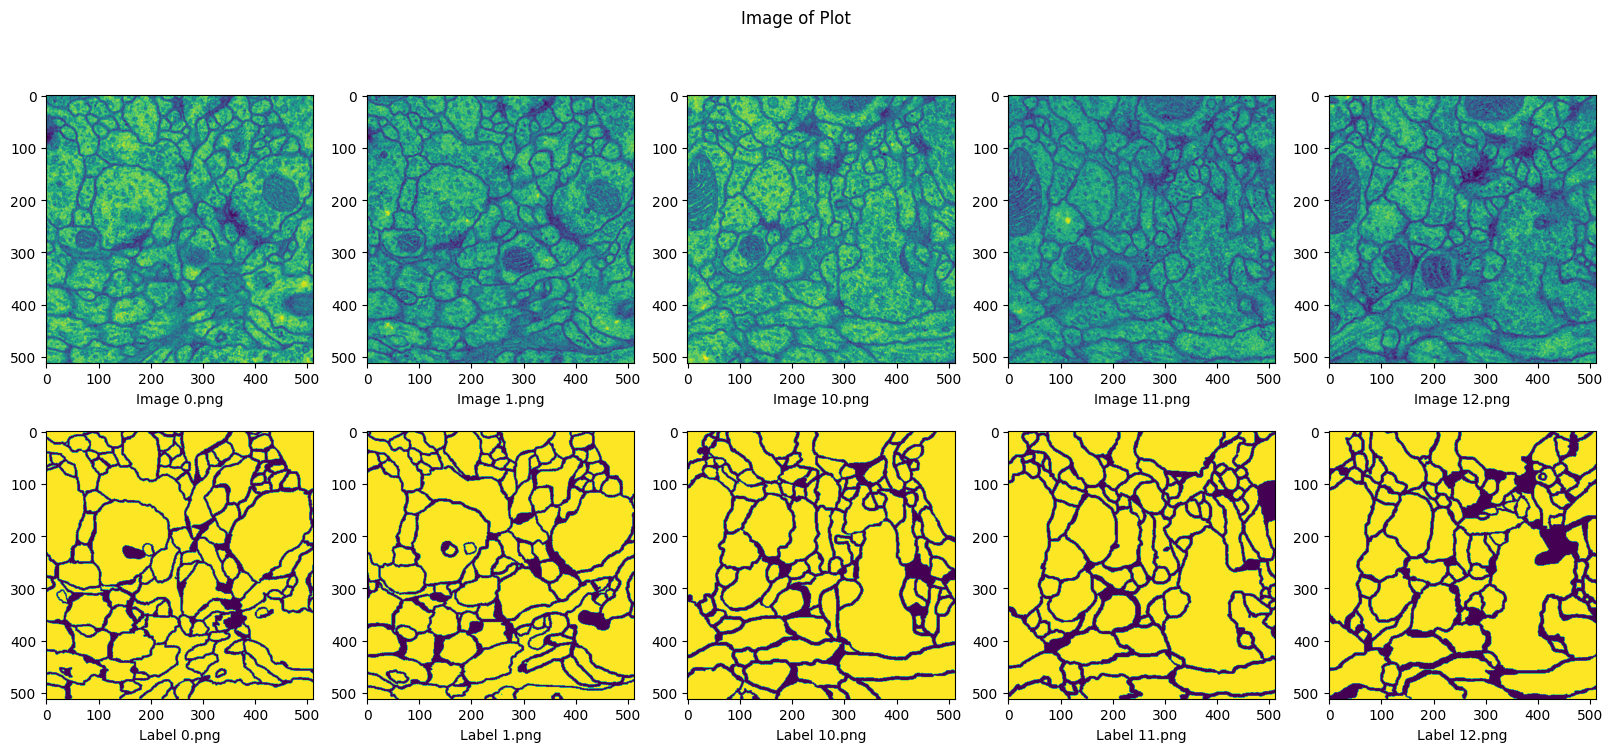

In [4]:
# Visualize top 5 ảnh đầu tiên
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# Khởi tạo subplot với 1 dòng 5 cột.
fg, ax = plt.subplots(2, 5, figsize=(20, 8))
fg.suptitle('Image of Plot')

for i, path in enumerate(img_5_paths):
  image = plt.imread(path)
  ax[0, i].imshow(image)
  ax[0, i].set_xlabel('Image ' + path.split('/')[-1])

for i, path in enumerate(label_5_paths):
  label = plt.imread(path)
  ax[1, i].imshow(label)
  ax[1, i].set_xlabel('Label ' + path.split('/')[-1])


**Mô hình U-Net có sự thay đổi kích thước Output so với Input**

In [5]:
import tensorflow as tf
INPUT_SHAPE = 572
OUTPUT_SHAPE = 386

def _downsample_cnn_block(block_input, channel, is_first = False):
  if is_first:
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(block_input)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(maxpool)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
    return [maxpool, conv1, conv2]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):
  # Upsampling block
  uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
  # Crop block counterpart
  shape_input = uppool1.shape[2]
  shape_counterpart = block_counterpart.shape[2]
  crop_size = int((shape_counterpart-shape_input)/2)
  block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
  concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
  conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(concat)
  conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
  if is_last:
    conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, activation='sigmoid')(conv2)
    return [concat, conv1, conv2, conv3]
  return [uppool1, concat, conv1, conv2]

In [6]:
from tensorflow.keras.optimizers import Adam

def _create_model():
  ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)), channel=64, is_first = True)
  ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
  us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model = _create_model()

In [7]:
from sklearn.model_selection import train_test_split
import glob2

image_augs = glob2.glob('unet/data/membrane/train/aug/*.png')
label_path_aug = [item for item in image_augs if 'mask_' in item]
image_names = [item.split('/')[-1] for item in label_path_aug]
image_path_aug = ['unet/data/membrane/train/aug/image'+item[4:] for item in image_names]

image_paths = glob2.glob('unet/data/membrane/train/image/*.png')
label_paths = ['unet/data/membrane/train/label/' + path.split('/')[-1] for path in image_paths]

image_paths += image_path_aug
label_paths += label_path_aug

train_img_paths, val_img_paths, train_label_paths, val_label_paths = train_test_split(image_paths, label_paths, test_size = 0.2)


In [8]:
import cv2

def _image_read_paths(train_img_paths, train_label_paths):
  X, Y = [], []
  for image_path, label_path in zip(train_img_paths, train_label_paths):
    image = cv2.imread(image_path)
    image_resize = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    label = cv2.imread(train_label_paths[0])
    label_gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label_resize = cv2.resize(label_gray, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label_binary = np.array(label_resize == 255).astype('float32')
    label_binary = label_binary[..., np.newaxis]
    X.append(image_resize)
    Y.append(label_binary)
  X = np.stack(X)
  Y = np.stack(Y)
  return X, Y

X_train, Y_train = _image_read_paths(train_img_paths, train_label_paths)
print(X_train.shape, Y_train.shape)
X_val, Y_val = _image_read_paths(val_img_paths, val_label_paths)
print(X_val.shape, Y_val.shape)

(72, 572, 572, 3) (72, 386, 386, 1)
(18, 572, 572, 3) (18, 386, 386, 1)


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 572, 572, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 570, 570, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 568, 568, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 284, 284, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

history=model.fit(X_train, Y_train,
  validation_data = (X_val, Y_val),
  batch_size = 8,
  epochs = 50
  # callbacks = (EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True))
  # callbacks = [lr_callback]
)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/50
9/9 [==============================] - 14s 2s/step - loss: 36689.6562 - accuracy: 0.4677 - val_loss: 55647.7656 - val_accuracy: 0.6866
Epoch 2/50
9/9 [==============================] - 14s 2s/step - loss: 193751.5000 - accuracy: 0.4896 - val_loss: 41371472.0000 - val_accuracy: 0.6143
Epoch 3/50
9/9 [==============================] - 14s 2s/step - loss: 338769696.0000 - accuracy: 0.5195 - val_loss: 2211059.7500 - val_accuracy: 0.3857
Epoch 4/50
9/9 [==============================] - 14s 2s/step - loss: 4513513984.0000 - accuracy: 0.4393 - val_loss: 54910816256.0000 - val_accuracy: 0.2709
Epoch 5/50
9/9 [==============================] - 14s 2s/step - loss: 256909213696.0000 - accuracy: 0.4632 - val_loss: 111704612864.0000 - val_accuracy: 0.7291
Epoch 6/50
9/9 [==============================] - 14s 2s/step - loss: 58345578496.0000 - accuracy: 0.5365 - val_loss: 20068464640.0000 - val_accuracy: 0.3858
Epoch 7/50
9/9 [==============================] - 14s 2s/step - loss: 2286405

<ipython-input-13-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


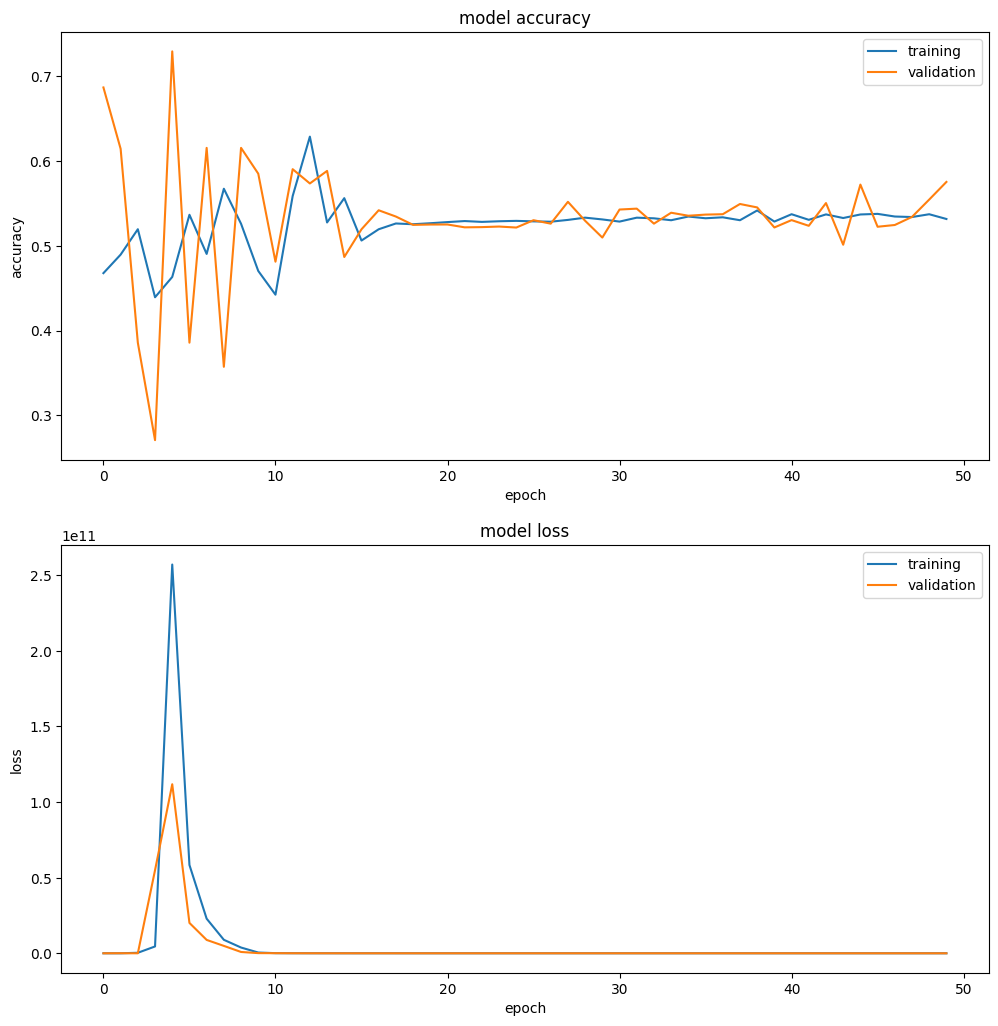

In [13]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)


1/1 [==============================] - 0s 29ms/step


<ipython-input-19-5a97322730bf>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


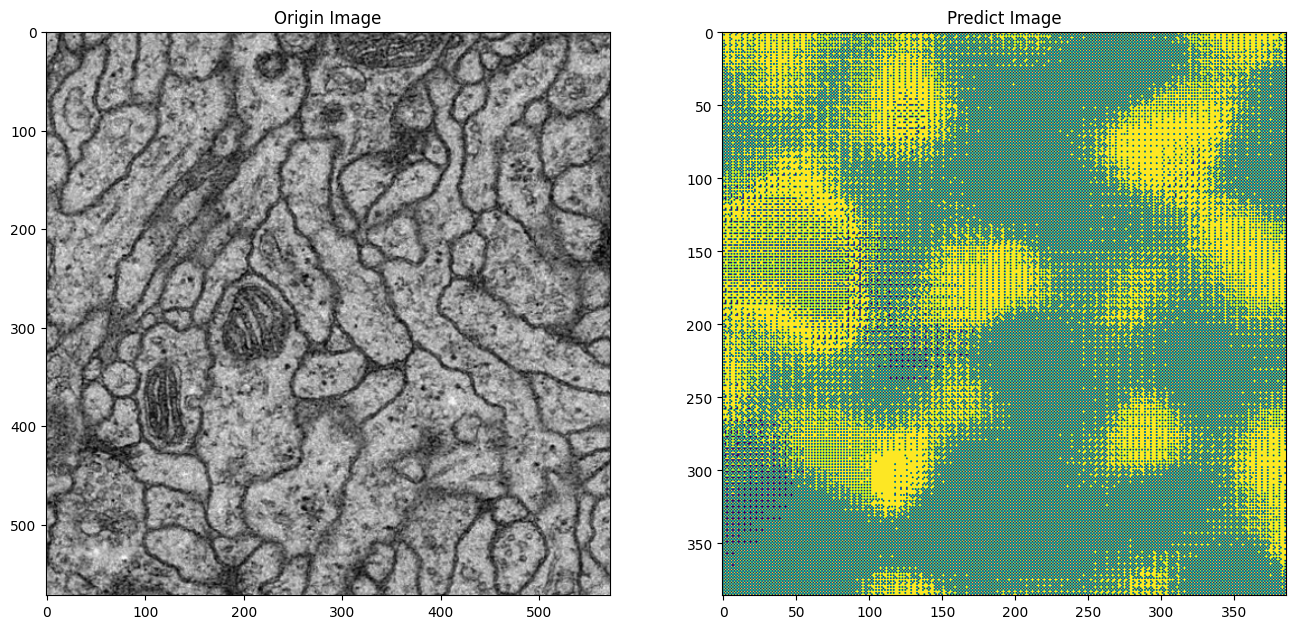

In [19]:
import glob2

test_paths = glob2.glob('unet/data/membrane/test/*.png')
test_paths = [path for path in test_paths if 'predict' not in path]

rand_ind = np.random.randint(5)
path = test_paths[rand_ind]

def _predict_path(path, figsize = (16, 8)):
  img = cv2.imread(path)
  img = cv2.resize(img, (572, 572), cv2.INTER_LINEAR)
  img_expand = img[np.newaxis, ...]
  img_pred = model.predict(img_expand).reshape(386, 386) # Change the reshape to match the model output
  img_pred[img_pred < 0.5] = 0
  img_pred[img_pred >= 0.5] = 1
  plt.subplots(figsize = figsize)
  plt.subplot(122)
  plt.title('Predict Image')
  plt.imshow(img_pred)
  plt.subplot(121)
  plt.title('Origin Image')
  plt.imshow(img)

_predict_path(path)

**Mô hình U-Net xây dựng có Output cùng kích thước với Input**

In [20]:
import tensorflow as tf

INPUT_SHAPE = 512
OUTPUT_SHAPE = 512

def _downsample_cnn_block(block_input, channel, is_first = False):
  if is_first:
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(block_input)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(maxpool)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    return [maxpool, conv1, conv2]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):
  # Upsampling block
  uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
  # Crop block counterpart
  shape_input = uppool1.shape[2]
  shape_counterpart = block_counterpart.shape[2]
  crop_size = int((shape_counterpart-shape_input)/2)
  # Có thể bỏ qua crop vì các nhánh đã bằng kích thước.
  block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
  concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
  conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(concat)
  conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
  if is_last:
    conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(conv2)
    return [concat, conv1, conv2, conv3]
  return [uppool1, concat, conv1, conv2]

In [21]:
from tensorflow.keras.optimizers import Adam

def _create_model2():
  ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)), channel=64, is_first = True)
  ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
  us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model2 = _create_model2()

In [22]:
import cv2

def _image_read_paths(train_img_paths, train_label_paths):
  X, Y = [], []
  for image_path, label_path in zip(train_img_paths, train_label_paths):
    image = cv2.imread(image_path)
    image_resize = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    label = cv2.imread(train_label_paths[0])
    label_gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label_resize = cv2.resize(label_gray, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label_binary = np.array(label_resize == 255).astype('float32')
    label_binary = label_binary[..., np.newaxis]
    # label_first_cn = np.array(label_resize == 255).astype('float32')
    # label_second_cn = np.array(label_resize == 0).astype('float32')
    # label_binary = np.stack([label_first_cn, label_second_cn], axis = 2)
    X.append(image_resize)
    Y.append(label_binary)
  X = np.stack(X)
  Y = np.stack(Y)
  return X, Y

X_train, Y_train = _image_read_paths(train_img_paths, train_label_paths)
print(X_train.shape, Y_train.shape)
X_val, Y_val = _image_read_paths(val_img_paths, val_label_paths)
print(X_val.shape, Y_val.shape)

(72, 512, 512, 3) (72, 512, 512, 1)
(18, 512, 512, 3) (18, 512, 512, 1)


In [24]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 512, 512, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 512, 512, 64)         36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 256, 256, 64)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

history=model2.fit(X_train, Y_train,
  validation_data = (X_val, Y_val),
  batch_size = 8,
  epochs = 50,
  # callbacks = (EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True))
)

Epoch 1/50
9/9 [==============================] - 17s 2s/step - loss: 50281.9961 - accuracy: 0.4673 - val_loss: 12202.9541 - val_accuracy: 0.5613
Epoch 2/50
9/9 [==============================] - 17s 2s/step - loss: 19435.4688 - accuracy: 0.4947 - val_loss: 28194.0898 - val_accuracy: 0.5797
Epoch 3/50
9/9 [==============================] - 18s 2s/step - loss: 23963.6855 - accuracy: 0.5158 - val_loss: 13430.9209 - val_accuracy: 0.4421
Epoch 4/50
9/9 [==============================] - 18s 2s/step - loss: 8819.0557 - accuracy: 0.5147 - val_loss: 8047.9253 - val_accuracy: 0.4033
Epoch 5/50
9/9 [==============================] - 18s 2s/step - loss: 3548.1494 - accuracy: 0.5307 - val_loss: 3047.4375 - val_accuracy: 0.6060
Epoch 6/50
9/9 [==============================] - 17s 2s/step - loss: 2150.4912 - accuracy: 0.5559 - val_loss: 1369.0454 - val_accuracy: 0.6178
Epoch 7/50
9/9 [==============================] - 17s 2s/step - loss: 958.0031 - accuracy: 0.6141 - val_loss: 448.1453 - val_accur

<ipython-input-30-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


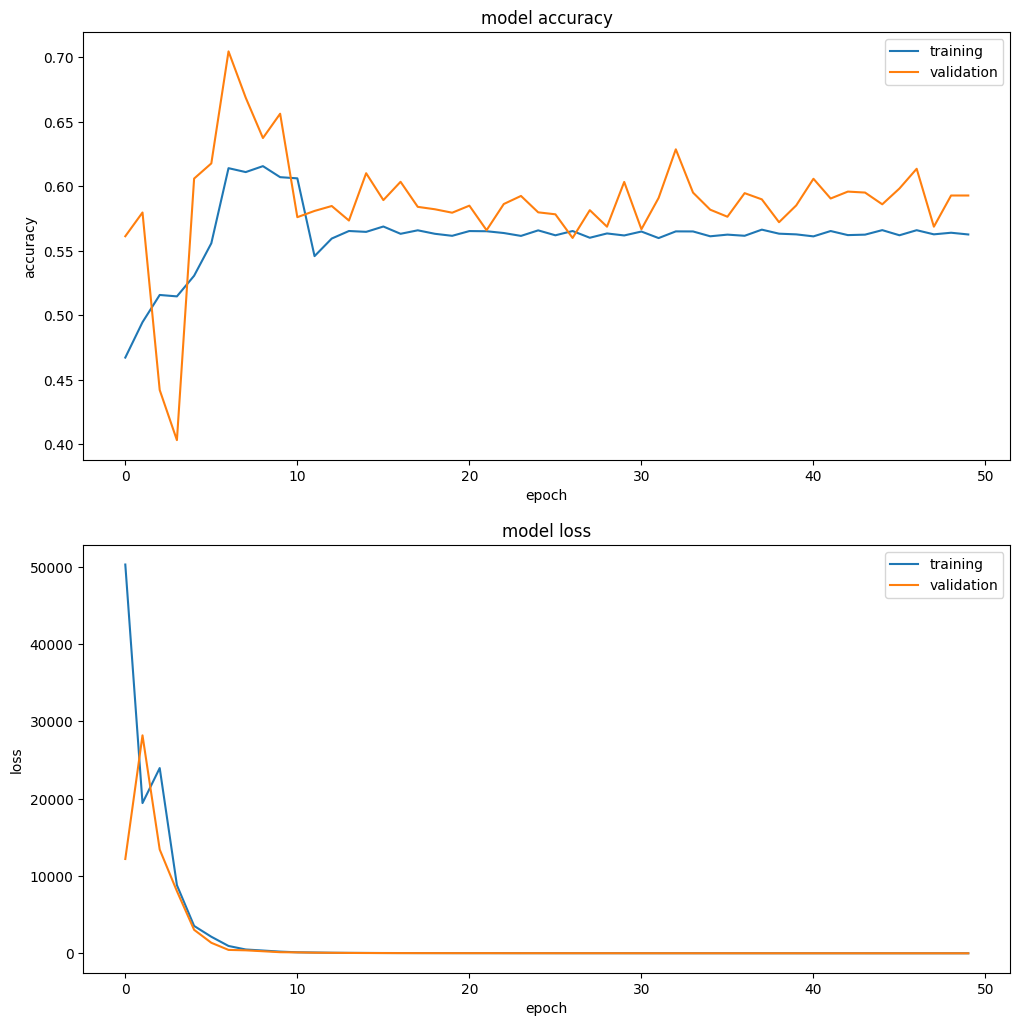

In [30]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

1/1 [==============================] - 6s 6s/step


<ipython-input-34-58a3e6a0e71f>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


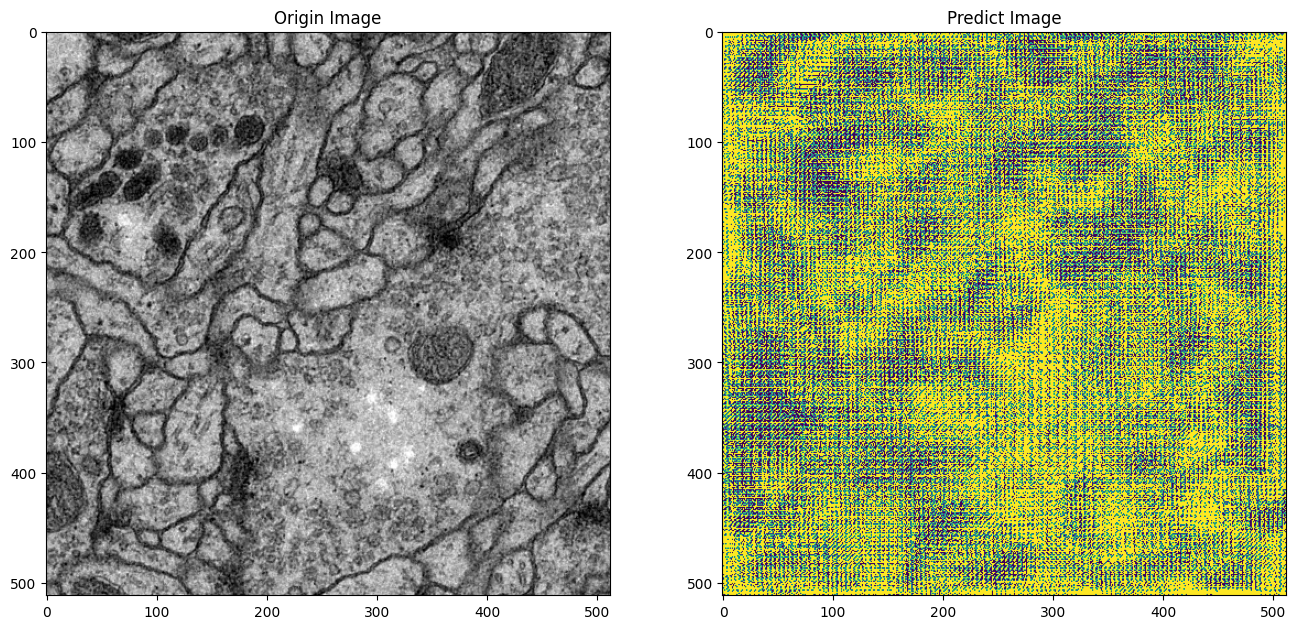

In [34]:
import glob2

test_paths = glob2.glob('unet/data/membrane/test/*.png')
test_paths = [path for path in test_paths if 'predict' not in path]

rand_ind = np.random.randint(5)
path = test_paths[rand_ind]

def _predict_path(path, figsize = (16, 8)):
  img = cv2.imread(path)
  img = cv2.resize(img, (512, 512), cv2.INTER_LINEAR)
  img_expand = img[np.newaxis, ...]
  img_pred = model2.predict(img_expand).reshape(512, 512) # Change the reshape to match the model output
  img_pred[img_pred < 0.5] = 0
  img_pred[img_pred >= 0.5] = 1
  plt.subplots(figsize = figsize)
  plt.subplot(122)
  plt.title('Predict Image')
  plt.imshow(img_pred)
  plt.subplot(121)
  plt.title('Origin Image')
  plt.imshow(img)

_predict_path(path)

***Thực hiện Data Augumentation (tăng cường dữ liệu) để cải thiện kích thước bộ dữ liệu huấn luyện ***

In [35]:
image_augs = glob2.glob('unet/data/membrane/train/aug/*.png')
label_path_aug = [item for item in image_augs if 'mask_' in item]
image_names = [item.split('/')[-1] for item in label_path_aug]
image_path_aug = ['unet/data/membrane/train/aug/image'+item[4:] for item in image_names]

image_paths = glob2.glob('unet/data/membrane/train/image/*.png')
label_paths = ['unet/data/membrane/train/label/' + path.split('/')[-1] for path in image_paths]

train_img_paths, val_img_paths, train_label_paths, val_label_paths = train_test_split(image_paths, label_paths, test_size = 0.2)

train_img_paths += image_path_aug
train_label_paths += label_path_aug

Text(0.5, 0, 'Label mask_5_2683761.png')

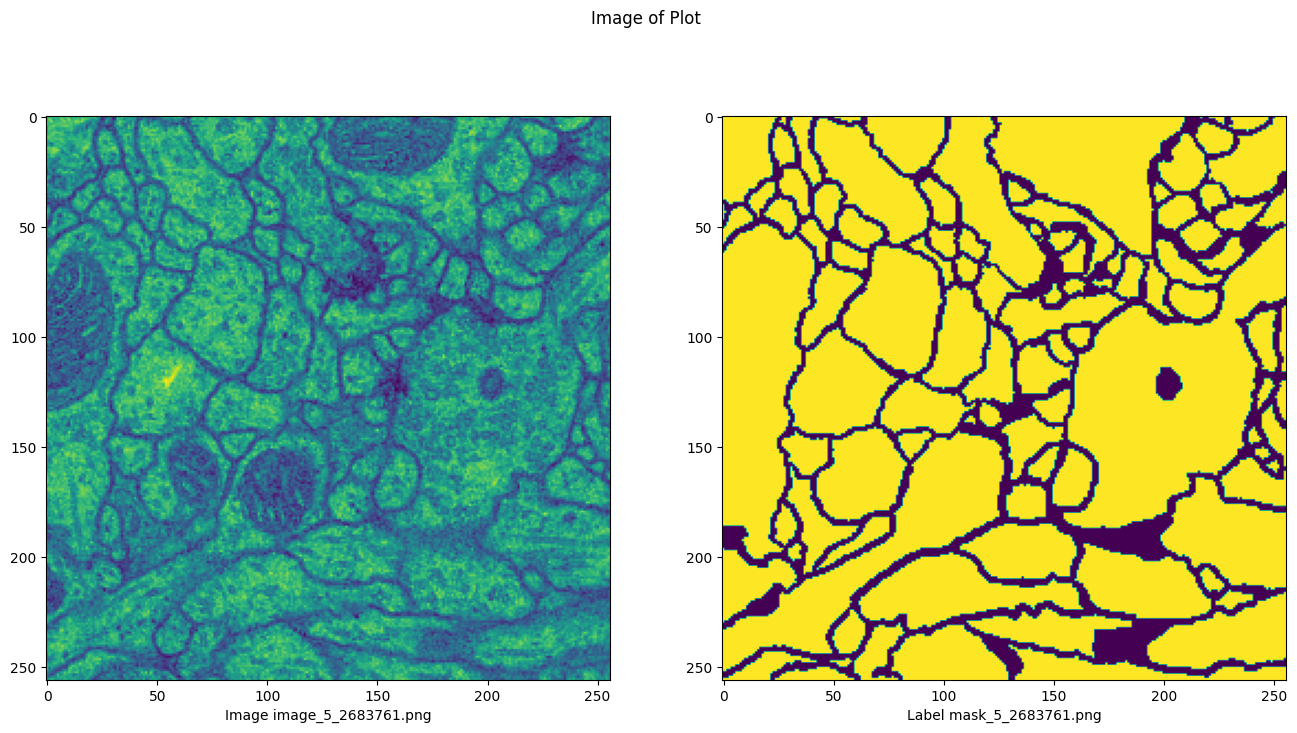

In [36]:
# Khởi tạo subplot với 1 dòng 5 cột.
fg, ax = plt.subplots(1, 2, figsize=(16, 8))
fg.suptitle('Image of Plot')

# Lựa chọn ngẫu nhiên một ảnh
rand_ind = np.random.randint(len(train_img_paths))
img_path = train_img_paths[rand_ind]
label_path = train_label_paths[rand_ind]

image = plt.imread(img_path)
ax[0].imshow(image)
ax[0].set_xlabel('Image ' + img_path.split('/')[-1])

label = plt.imread(label_path)
ax[1].imshow(label)
ax[1].set_xlabel('Label ' + label_path.split('/')[-1])


In [37]:
import numpy as np
from tensorflow.keras.utils import Sequence
import cv2

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,
                 all_filenames,
                 labels,
                 batch_size,
                 input_dim,
                 n_channels,
                 normalize,
                 zoom_range,
                 rotation,
                 brightness_range,
                 shuffle=True):
        '''
        all_filenames: list toàn bộ các filename
        labels: nhãn của toàn bộ các file
        batch_size: kích thước của 1 batch
        input_dim: (width, height) đầu vào của ảnh
        n_channels: số lượng channels của ảnh
        normalize: Chuẩn hóa ảnh
        zoom_range: Kích thước scale
        rotation: Độ xoay của ảnh
        brightness_range: Độ sáng
        shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
        '''
        self.all_filenames = all_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.normalize = normalize
        self.zoom_range = zoom_range
        self.rotation = rotation
        self.brightness_range = brightness_range
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        '''
        return:
          Trả về số lượng batch/1 epoch
        '''
        return int(np.floor(len(self.all_filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        params:
          index: index của batch
        return:
          X, Y cho batch thứ index
        '''
        # Lấy ra indexes của batch thứ index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # List all_filenames trong một batch
        all_filenames_temp = [self.all_filenames[k] for k in indexes]

        # Khởi tạo data
        X, Y = self.__data_generation(all_filenames_temp)

        return X, Y

    def on_epoch_end(self):
        '''
        Shuffle dữ liệu khi epochs end hoặc start.
        '''
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        '''
        params:
          all_filenames_temp: list các filenames trong 1 batch
        return:
          Trả về giá trị cho một batch.
        '''
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        Y = np.empty((self.batch_size, *self.input_dim, self.n_channels))

        # Khởi tạo dữ liệu
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # Đọc file từ folder name
            img = cv2.imread(fn)
            label = cv2.imread(label_fn)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.input_dim)
            label = cv2.resize(label, self.input_dim)

            if self.normalize:
              mean1 = np.mean(img, axis=0)
              std1 = np.std(img, axis=0)
              img = (img-mean1)/std1

            if self.zoom_range:
              zoom_scale = 1/np.random.uniform(self.zoom_range[0], self.zoom_range[1])
              (h, w, c) = img.shape
              img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              label = cv2.resize(label, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              label = label/255
              label[label > 0.5] = 1
              label[label < 0.5] = 0
              (h_rz, w_rz, c) = img.shape
              start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
              start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
              # print(start_w, start_h)
              img = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
              label = label[start_h:(start_h+h), start_w:(start_w+w), :].copy()

            if self.rotation:
              (h, w, c) = img.shape
              angle = np.random.uniform(-self.rotation, self.rotation)
              RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
              img = cv2.warpAffine(img, RotMat, (w, h))
              label = cv2.warpAffine(label, RotMat, (w, h))

            if self.brightness_range:
              scale_bright = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
              img = img*scale_bright

            label = label > 0.5
            X[i,] = img
            # Lưu class
            Y[i,] = label
        return X, Y

In [38]:
train_generator = DataGenerator(
    all_filenames = list(zip(train_img_paths, train_label_paths)),
    labels = train_label_paths,
    batch_size = 8,
    input_dim = (512, 512),
    n_channels = 3,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

val_generator = DataGenerator(
    all_filenames = list(zip(val_img_paths, val_label_paths)),
    labels = val_label_paths,
    batch_size = 8,
    input_dim = (512, 512),
    n_channels = 3,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

X_batch, Y_batch = train_generator.__getitem__(index=0)
print(X_batch.shape, Y_batch.shape)

(8, 512, 512, 3) (8, 512, 512, 3)


<ipython-input-39-d51cbd8bc990>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


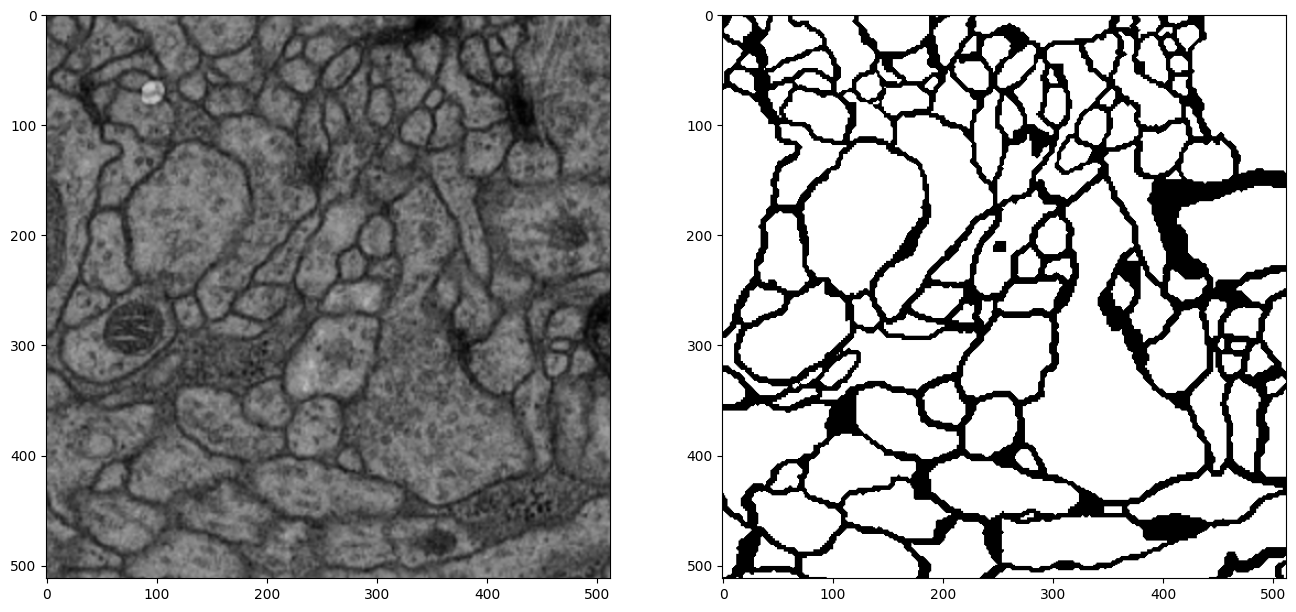

In [39]:
# Khởi tạo subplot với 1 dòng 2 cột.
rand_ind = np.random.randint(8)

plt.subplots(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X_batch[rand_ind]/255)
plt.subplot(122)
plt.imshow(Y_batch[rand_ind])

In [40]:
model3 = _create_model2()

history = model3.fit_generator(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=val_generator,
          validation_steps=5,
          epochs=50,
          # callbacks = (EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))
          )

<ipython-input-40-6972a17abc84>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator,


Epoch 1/50
10/10 [==============================] - 25s 2s/step - loss: 47583.8047 - accuracy: 0.4975
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 313372.4375 - accuracy: 0.4344
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 1359961.5000 - accuracy: 0.5106
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 1874208.7500 - accuracy: 0.4525
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 10831521.0000 - accuracy: 0.5067
Epoch 6/50
10/10 [==============================] - 18s 2s/step - loss: 275131936.0000 - accuracy: 0.4583
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 388290496.0000 - accuracy: 0.5043
Epoch 8/50
10/10 [==============================] - 17s 2s/step - loss: 3564847104.0000 - accuracy: 0.4896
Epoch 9/50
10/10 [==============================] - 17s 2s/step - loss: 15109494784.0000 - accuracy: 0.4792
Epoch 10/50
10/10 [==============================] - 17

KeyError: 'val_accuracy'

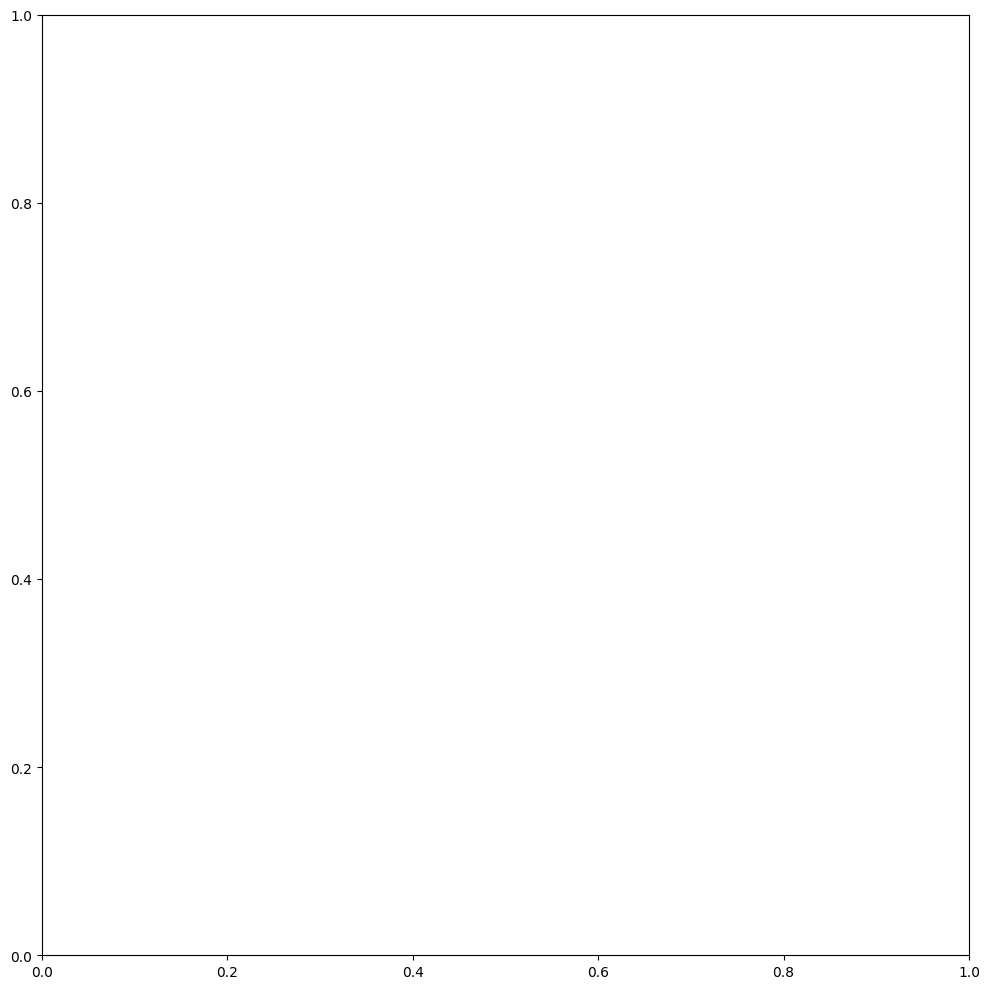

In [41]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)


In [ ]:
import glob2

test_paths = glob2.glob('unet/data/membrane/test/*.png')
test_paths = [path for path in test_paths if 'predict' not in path]

rand_ind = np.random.randint(5)
path = test_paths[rand_ind]

def _predict_path(path, figsize = (16, 8)):
  img = cv2.imread(path)
  img = cv2.resize(img, (512, 512), cv2.INTER_LINEAR)
  img_expand = img[np.newaxis, ...]
  img_pred = model3.predict(img_expand).reshape(512, 512) # Change the reshape to match the model output
  img_pred[img_pred < 0.5] = 0
  img_pred[img_pred >= 0.5] = 1
  plt.subplots(figsize = figsize)
  plt.subplot(122)
  plt.title('Predict Image')
  plt.imshow(img_pred)
  plt.subplot(121)
  plt.title('Origin Image')
  plt.imshow(img)

_predict_path(path)